In [ ]:
import torch
from transformers import ASTModel
import torch.nn as nn  # Import the nn module from PyTorch
from models.dino import UniModalDINO, UniModalDINOLightning, SpectrogramEncoder
from training_structures.dino_train import train_knn_classifier
from utils.get_data import get_dataloader_augmented
%load_ext autoreload
%autoreload 2
import torch
torch.manual_seed(0) # Set seed before importing other modules
import numpy as np
np.random.seed(0)
import random
random.seed(0)
import sys
import os
from models.unimodal import CentralUnimodalImage, CentralUnimodalAudio, UnimodalImage
import torch.nn as nn
import torch.optim as optim
from utils.get_data import get_dataloader_augmented
from training_structures.unimodal import train as unimodal_train, test as unimodal_test
from models.centralnet.centralnet import SimpleAV_CentralNet as CentralNet
from training_structures.centralnet_train import train_centralnet, test_centralnet
import matplotlib.pyplot as plt
from utils.visualisations import show_images, show_images_augmentations, evaluate_results, plot_training_results_from_csv, plot_training_results_from_csvs
from torchvision import transforms, datasets
from torchmetrics.classification import Accuracy
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import lightning.pytorch as pl
from lightning.pytorch.strategies import DDPStrategy
import torch.multiprocessing
# torch.multiprocessing.set_start_method('spawn')

current_path = os.getcwd()
sys.path.append(current_path)

# Load the pretrained AST model from Hugging Face
# model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"  # Fine-tuned on AudioSet
# model = ASTModel.from_pretrained(model_name)

# # Modify the model's patch embedding layer
# # model.embeddings.patch_embeddings.projection = nn.Conv2d(
# #     in_channels=1,  # Spectrograms are 1-channel
# #     out_channels=768,  # Keep output dim the same
# #     kernel_size=(8, 8),  # Smaller patches if needed
# #     stride=(4, 4)  # Adjust stride for desired number of patches
# # )

# # Set the model to evaluation mode (important for inference)
# model.eval()

c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = f'{current_path}/data/avmnist/'
# data_module = AVMNISTDataModule(data_dir)
# data_module.setup()
# traindata = data_module.train_dataloader()
# validdata = data_module.val_dataloader()
# testdata = data_module.test_dataloader()

In [3]:
traindata, validdata, testdata = get_dataloader_augmented(data_dir, type="burst_noise", batch_size=128, num_workers=0)

In [4]:
# all_means = []
# all_stds = []
# all_mins = []
# all_maxs = []

# for image, audio, label in traindata:  # Or trainloader if you want training set stats
#     all_means.append(audio.mean().item())
#     all_stds.append(audio.std().item())
#     all_mins.append(audio.min().item())
#     all_maxs.append(audio.max().item())

# # Compute dataset-wide statistics
# dataset_mean = sum(all_means) / len(all_means)
# dataset_std = sum(all_stds) / len(all_stds)
# dataset_min = min(all_mins)
# dataset_max = max(all_maxs)

# print(f"Dataset Mean: {dataset_mean:.4f}")
# print(f"Dataset Std: {dataset_std:.4f}")
# print(f"Dataset Min: {dataset_min:.4f}")
# print(f"Dataset Max: {dataset_max:.4f}")

In [5]:
# audio[5]

In [6]:
# from utils.visualisations import show_images
# zero_count = 0
# total_samples = 0

# for image, audio, label in traindata:
#     for spectrogram in audio:  # Iterate over all spectrograms in the batch
#         total_samples += 1
#         if torch.all(torch.isclose(spectrogram, torch.tensor(0.0, dtype=spectrogram.dtype))):
#             zero_count += 1

# print(f"Zero spectrograms: {zero_count}/{total_samples} ({(zero_count / total_samples) * 100:.2f}%)")

In [7]:
# from utils.visualisations import show_images

# for image, audio, label in traindata:
#     print(f"Batch of images | image: {image.shape} | audio: {audio.shape} | label: {label.shape}")
#     spectrograms = torch.nn.functional.interpolate(
#         audio, size=(128, 1024), mode="bilinear", align_corners=False
#     )
#     show_images(image[1], spectrograms[1], label[1])
#     break  # Test one batch

In [8]:
# # # Create a dummy input spectrogram (values between 0 and 1)
# # batch_size = 4
# # dummy_spectrograms = torch.rand(batch_size, 1, 112, 112)  # (B, 1, 112, 112)

# # # Resize to AST's expected input size (128x128) using interpolation
# # dummy_spectrograms = torch.nn.functional.interpolate(dummy_spectrograms, size=(128, 1024), mode="bilinear", align_corners=False)
# # # Remove the channel dimension (AST expects (B, time, freq))
# # dummy_spectrograms = dummy_spectrograms.squeeze(1)  # Now (B, 128, 128)

# # # Ensure the tensor is on the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model.to(device)
# # dummy_spectrograms = dummy_spectrograms.to(device)

# # print(dummy_spectrograms.shape)  # Should be (4, 1, 128, 128)

In [9]:
class SpectrogramEncoderAST(SpectrogramEncoder):
    def __init__(self, output_dim=128, pretrained=False):
        super().__init__(output_dim=output_dim)
        
        # Load the pretrained AST model
        model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
        self.encoder = ASTModel.from_pretrained(model_name)
        self.encoder.eval()

        # Output projection layer
        self.projection = nn.Linear(self.encoder.config.hidden_size, output_dim)

    def forward(self, images=None, spectrograms=None):
        if spectrograms is None:
            raise ValueError("SpectrogramEncoder requires spectrogram input")

        # Resize to AST's expected input size (128x1024)
        spectrograms = torch.nn.functional.interpolate(
            spectrograms, size=(128, 1024), mode="bilinear", align_corners=False
        )
        
        # Remove channel dimension
        spectrograms = spectrograms.squeeze(1)  # (B, 128, 1024)
        
        with torch.no_grad(), torch.amp.autocast('cuda'):
            # Forward pass through AST
            features = self.encoder(spectrograms).last_hidden_state  # (B, num_patches+1, hidden_dim)
        
        # # Extract [CLS] token features
        cls_features = features[:, 0, :]  # (B, hidden_dim)
        
        # # Project to output_dim
        # projected_features = self.projection(cls_features)  # (B, output_dim)
        
        return cls_features
        # return projected_features


In [10]:
# encoder_ast = SpectrogramEncoderAST(output_dim=128, pretrained=True)
model = UniModalDINO(
    encoder_class = SpectrogramEncoderAST,
    # encoder_kwargs={'pretrained': True},
)
model = model.to(device)

In [11]:
knn_model, knn_accuracy = train_knn_classifier(model, traindata, testdata, n_neighbors=5)

Extracting training features...


100%|██████████| 430/430 [11:17<00:00,  1.58s/it]


Extracting test features...


100%|██████████| 79/79 [02:07<00:00,  1.61s/it]


Training KNN classifier...
KNN Accuracy (k=5): 0.1471


100%|██████████| 79/79 [00:01<00:00, 57.93it/s]


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


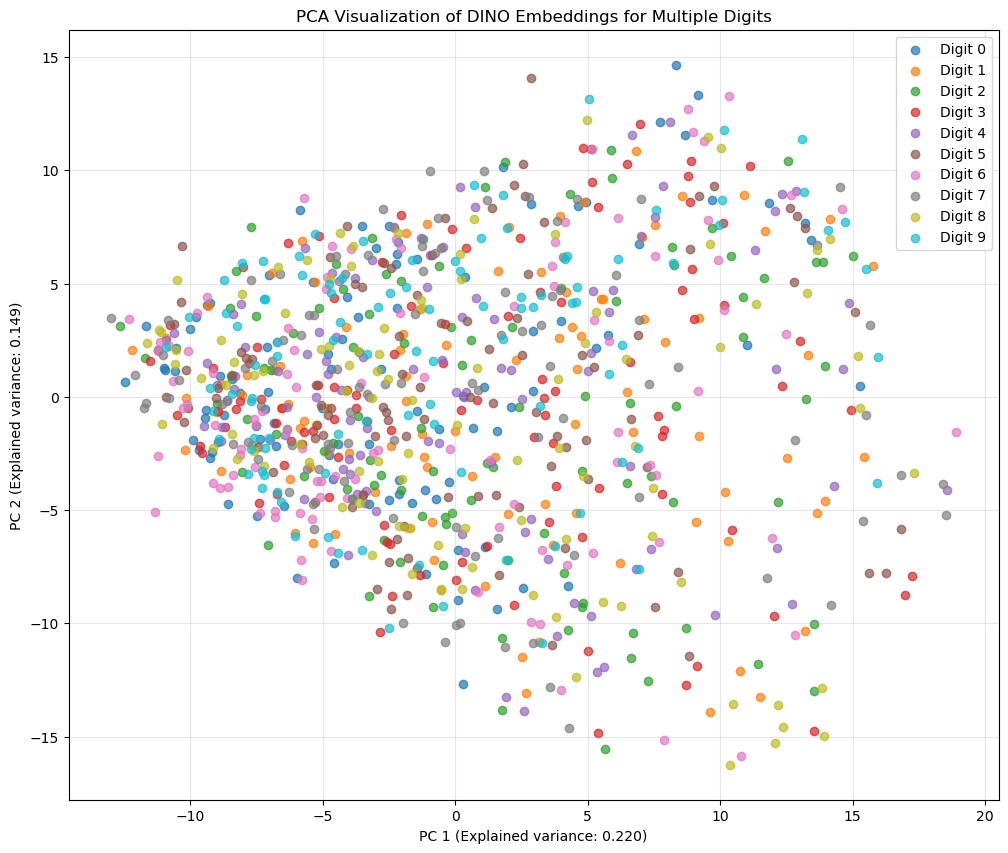

In [13]:
from utils.visualisations import pca_plot_multiclass
model_path = f'{current_path}/temp/ast_pretrained/'
_ = pca_plot_multiclass(model, testdata, selected_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dirpath=model_path, show_plots=True)

In [12]:
# from training_structures.dino_train import train_downstream
# model_path = f'{current_path}/temp/ast_pretrained'
# model_name = 'ast_pretrained_audio'
# classifier = train_downstream(
#         model,
#         traindata,
#         validdata,
#         testdata,
#         num_epochs=10,
#         device=device,
#         save_path=f'{model_path}/downstream/{model_name}.pt',
#         train_log_path=f'{model_path}/downstream/{model_name}_train_log.csv',
#         test_log_path=f'{model_path}/downstream/{model_name}_test_log.csv',
#     )